In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# 1. 读取数据
df = pd.read_csv("English_news.csv")  # 替换为你的文件名
df = df.dropna(subset=['content'])  # 移除空值
texts = df['content'].tolist()

# 可选：抽样用于快速测试（取消下面一行注释）
# texts = texts[:10000]

# 2. 编码文本为向量
print("Encoding texts using Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')  # 轻量快速模型
embeddings = model.encode(texts, show_progress_bar=True, batch_size=128)

# 3. 使用肘部法则找最佳k值
print("Computing inertia for different k values...")
inertias = []
K = range(2, 12)  # 尝试2~15个主题
for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)


d:\Anaconda3\envs\ChinaDaily\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoding texts using Sentence-BERT...


Batches: 100%|██████████| 3227/3227 [1:33:14<00:00,  1.73s/it]  


Computing inertia for different k values...


100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


C:\Users\yk\AppData\Local\Temp\ipykernel_113900\1106649300.py:8: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.savefig("elbow_plot.png")
C:\Users\yk\AppData\Local\Temp\ipykernel_113900\1106649300.py:8: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from font(s) DejaVu Sans.
  plt.savefig("elbow_plot.png")
C:\Users\yk\AppData\Local\Temp\ipykernel_113900\1106649300.py:8: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from font(s) DejaVu Sans.
  plt.savefig("elbow_plot.png")
C:\Users\yk\AppData\Local\Temp\ipykernel_113900\1106649300.py:8: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  plt.savefig("elbow_plot.png")
C:\Users\yk\AppData\Local\Temp\ipykernel_113900\1106649300.py:8: UserWarning: Glyph 26041 (\N{CJK UNIFIED IDEOGRAPH-65B9}) missing from font(s) DejaVu Sans.
  plt.savefig("elbow_plot.png")
C:\Users\yk\AppData\Local\Temp\ipykernel_113900\1106649

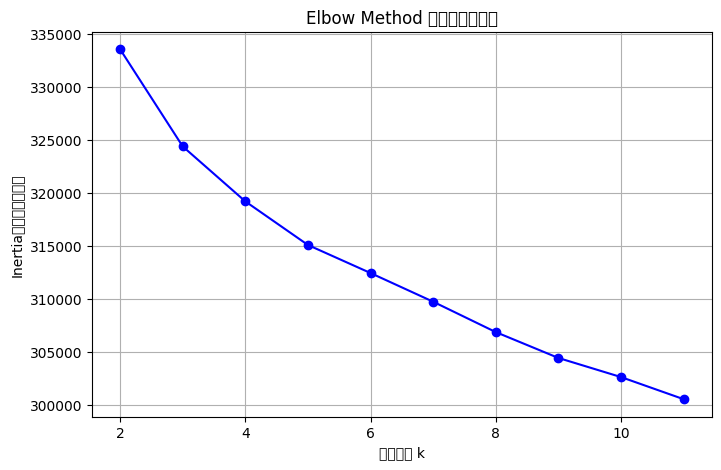

In [2]:
# 4. 可视化肘部图
plt.figure(figsize=(8, 5))
plt.plot(K, inertias, 'bo-')
plt.xlabel("主题数量 k")
plt.ylabel("Inertia（误差平方和）")
plt.title("Elbow Method 选择最佳聚类数")
plt.grid(True)
plt.savefig("elbow_plot.png")
plt.show()


In [3]:
# 5. 手动设置最佳k（根据图观察拐点）：
best_k = 10

In [4]:
# 6. 聚类并添加标签
print(f"正在以 k={best_k} 进行KMeans聚类...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(embeddings)

df['main_topic'] = labels

# 7. 保存结果
df.to_csv("Bert_topics10_English_news.csv", index=False)
print("带有主题标签的数据已保存为 Bert_topics10.csv")

正在以 k=10 进行KMeans聚类...
带有主题标签的数据已保存为 Bert_topics10.csv


In [6]:
import pandas as pd

df = pd.read_csv("Bert_topics10_English_news.csv")  # 替换为你的文件名
df = df.head(500)
df.to_csv("Bert_topics10_English_news_head500.csv", index=False)

In [9]:
import pandas as pd

df = pd.read_csv("./Bert_topics10.csv")  # 替换为你的文件名
df_6 = df[df['main_topic'] == 6]

df_6.to_csv("sci&tech_news_us_mentioned.csv", index=False)

print(len(df_6))

10004


In [17]:
df_sorted = df_6.sort_values('date')

# 均匀抽样方法1：使用np.linspace计算均匀间隔的索引
indices = np.linspace(0, len(df_sorted)-1, 1000, dtype=int)
sample = df_sorted.iloc[indices]

print(len(sample))
sample.to_csv("Bert_topics7_English_news_topic6_sample1000.csv", index=False)

1000


In [28]:
import pandas as pd

df = pd.read_csv("Bert_topics7_English_news.csv")  # 替换为你的文件名

# 确保日期是datetime类型
df['date'] = pd.to_datetime(df['date'])

df = df[df['date'].dt.year >= 2010]


# 创建年月列
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# 计算每月各主题数量
topic_counts = df.groupby(['year_month', 'main_topic']).size().unstack(fill_value=0)

# 计算每月总报道量
monthly_totals = topic_counts.sum(axis=1)

# 计算各主题占比（百分比）
topic_percentages = topic_counts.div(monthly_totals, axis=0) * 100

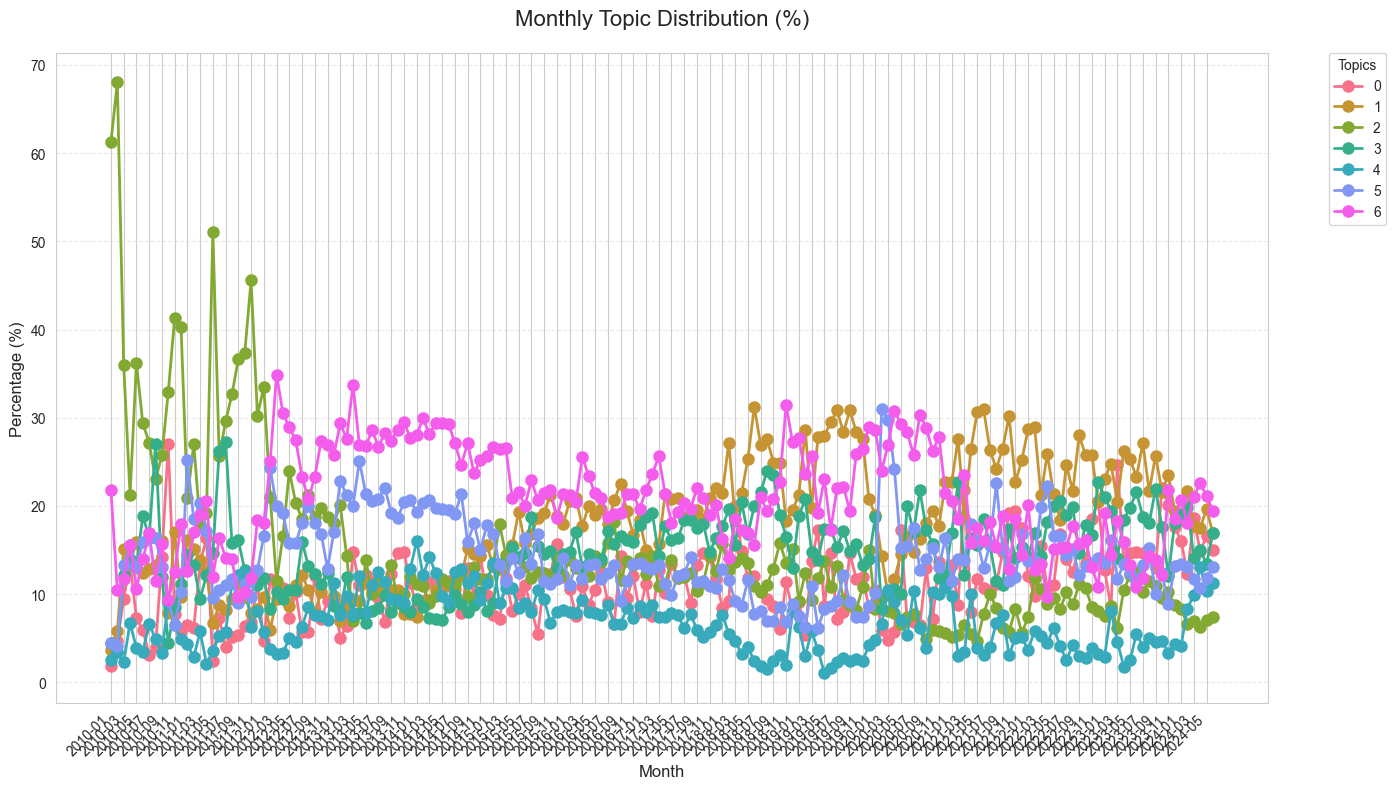

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置样式（新版正确写法）
sns.set_style("whitegrid")  # 使用seaborn的白色网格风格
plt.figure(figsize=(14, 8))

# 颜色映射
palette = sns.color_palette("husl", len(topic_percentages.columns))

# 绘制所有折线
for i, topic in enumerate(topic_percentages.columns):
    plt.plot(topic_percentages.index, 
             topic_percentages[topic], 
             marker='o', 
             linestyle='-',
             linewidth=2,
             color=palette[i],
             label=topic,
             markersize=8)

# 图表装饰
plt.title('Monthly Topic Distribution (%)', fontsize=16, pad=20)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(topic_percentages.index[::2], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4)

# 图例设置
plt.legend(bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           borderaxespad=0.,
           frameon=True,
           title='Topics')

plt.tight_layout()
plt.show()

In [30]:
# 原数据准备（假设已有）
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.to_period('Q').astype(str)  # 如"2023Q1"
df['year_month'] = df['date'].dt.to_period('M').astype(str)

# 计算季度占比
quarterly = (df.groupby(['quarter', 'main_topic']).size()
            .unstack(fill_value=0))
quarterly_pct = quarterly.div(quarterly.sum(axis=1), axis=0) * 100

# 计算年度占比
yearly = (df.groupby(['year', 'main_topic']).size()
         .unstack(fill_value=0))
yearly_pct = yearly.div(yearly.sum(axis=1), axis=0) * 100

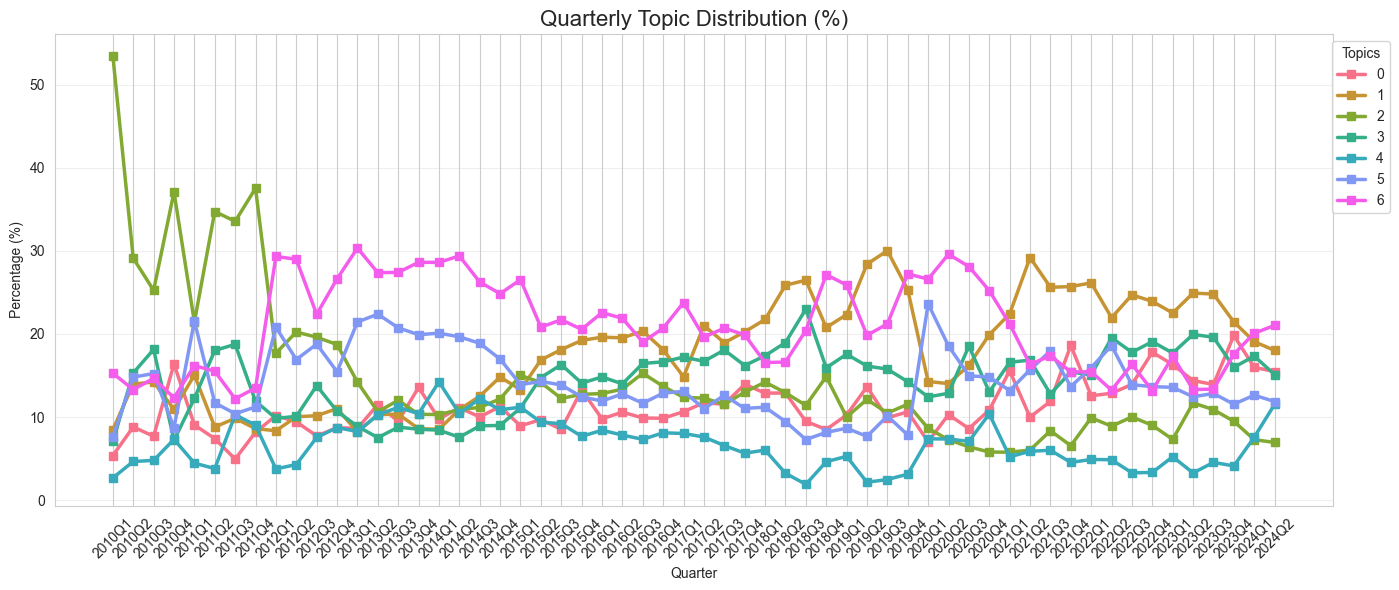

In [31]:
plt.figure(figsize=(14, 6))
palette = sns.color_palette("husl", len(quarterly_pct.columns))

for i, topic in enumerate(quarterly_pct.columns):
    plt.plot(quarterly_pct.index, 
             quarterly_pct[topic], 
             marker='s',  # 方形标记
             color=palette[i],
             label=topic,
             linewidth=2.5)

plt.title('Quarterly Topic Distribution (%)', fontsize=16)
plt.ylabel('Percentage (%)')
plt.xlabel('Quarter')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), title='Topics')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

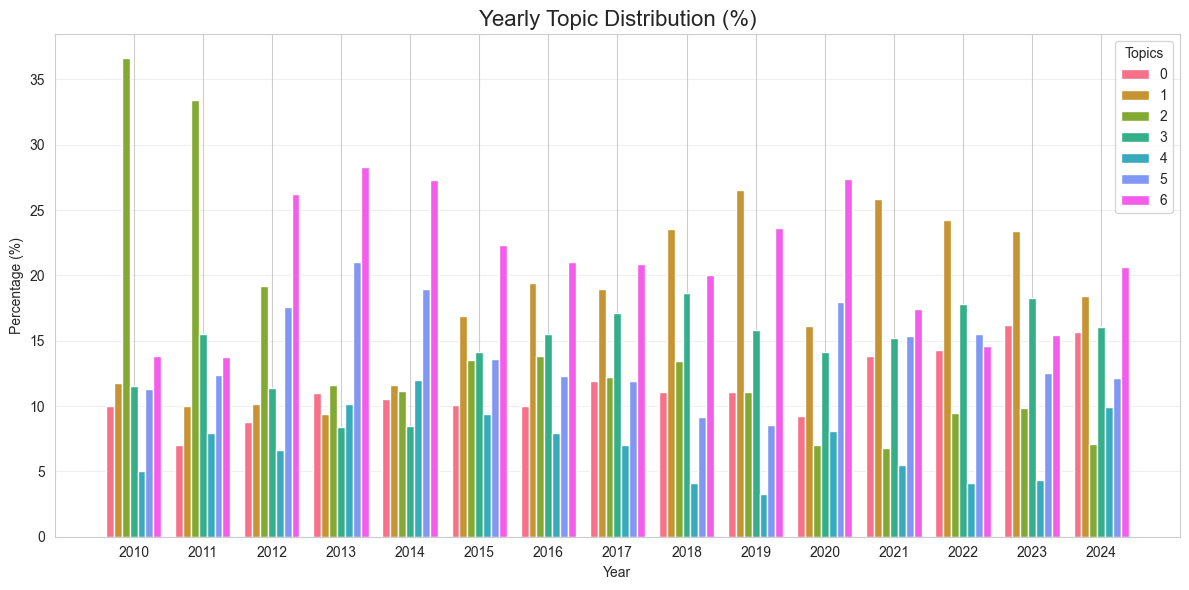

In [32]:
plt.figure(figsize=(12, 6))
width = 0.8 / len(yearly_pct.columns)  # 动态调整柱宽

for i, topic in enumerate(yearly_pct.columns):
    positions = yearly_pct.index.astype(int) + i*width
    plt.bar(positions, 
            yearly_pct[topic], 
            width=width,
            color=palette[i],
            label=topic,
            edgecolor='white')

plt.title('Yearly Topic Distribution (%)', fontsize=16)
plt.ylabel('Percentage (%)')
plt.xlabel('Year')
plt.xticks(yearly_pct.index.astype(int) + width*(len(yearly_pct.columns)-1)/2, 
           yearly_pct.index)
plt.legend(title='Topics')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

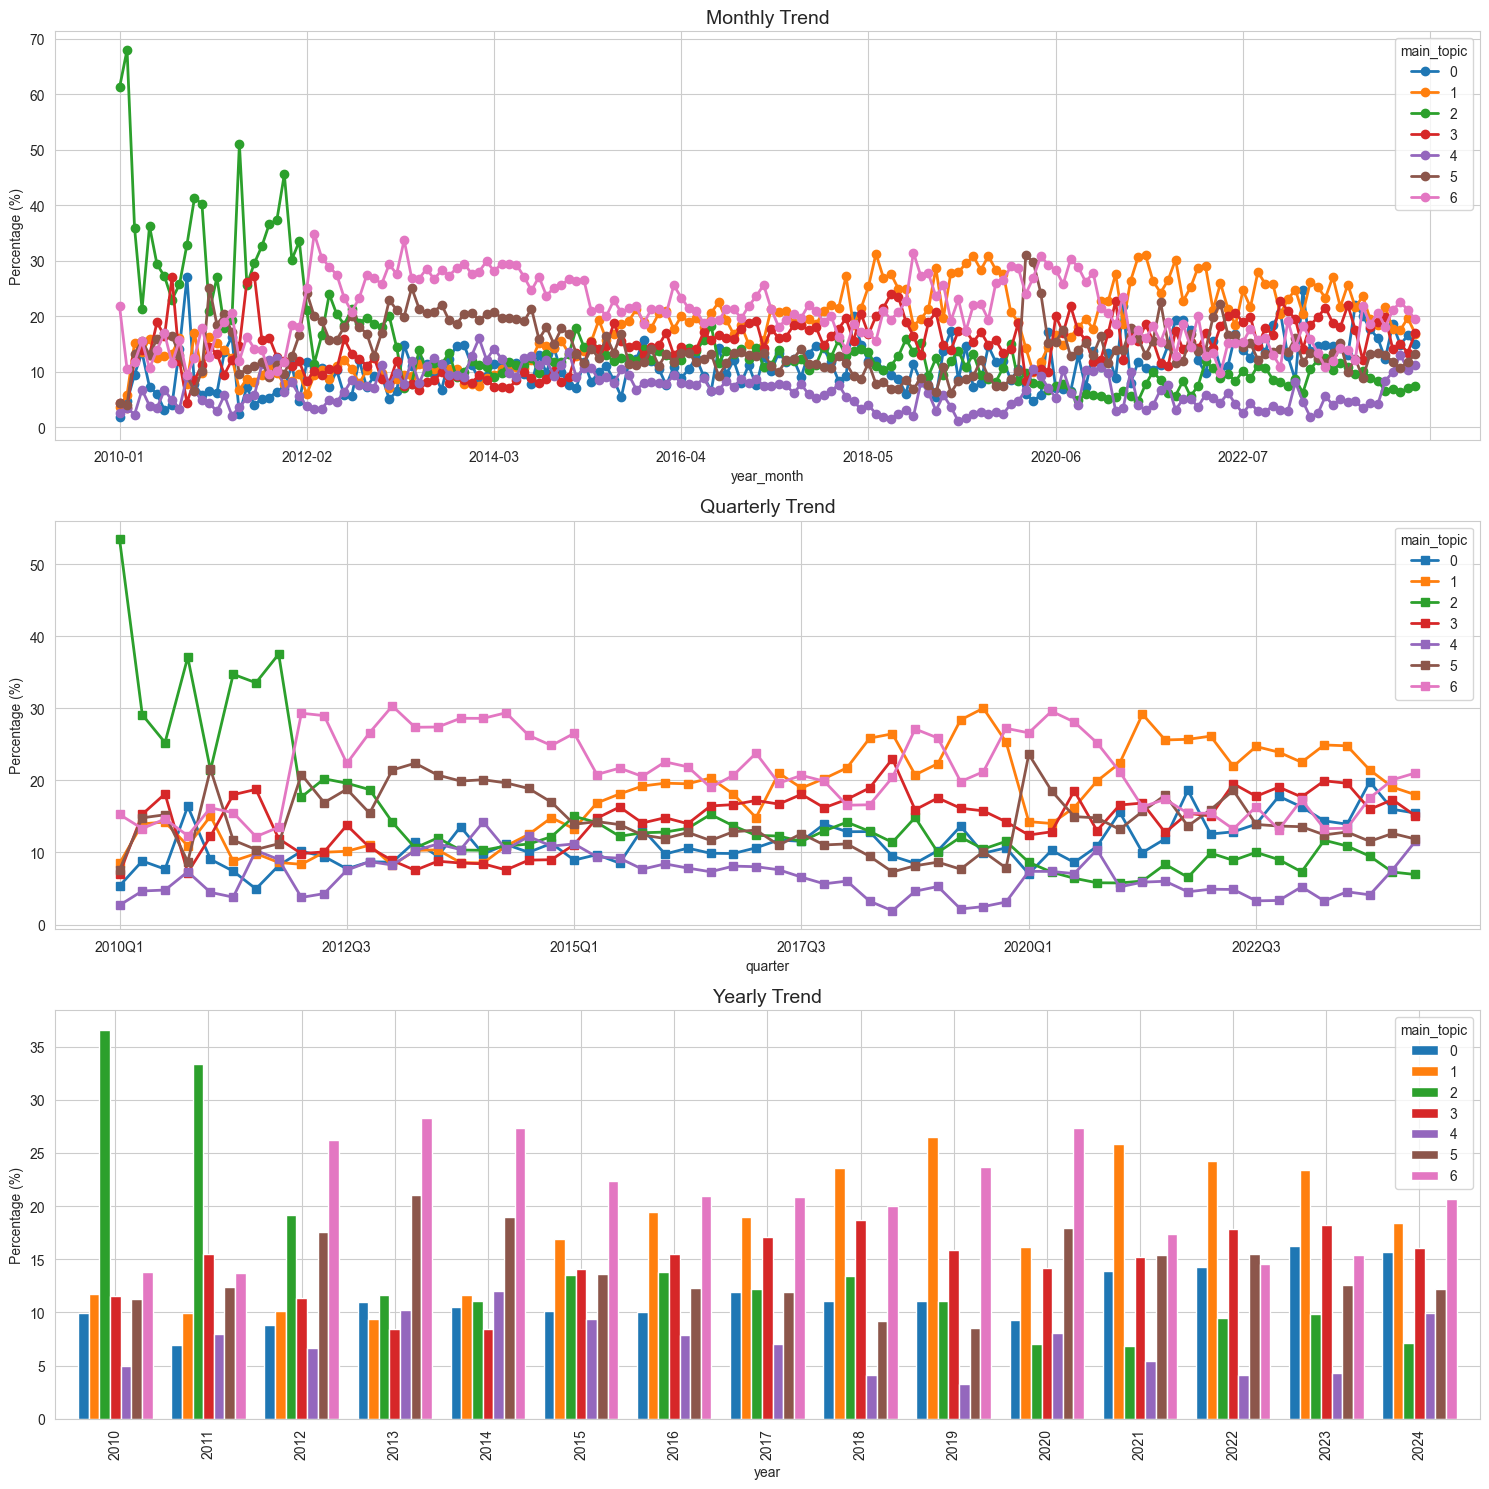

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))

# 月度
topic_percentages.plot(ax=ax1, marker='o', linewidth=2)
ax1.set_title('Monthly Trend', fontsize=14)
ax1.set_ylabel('Percentage (%)')

# 季度
quarterly_pct.plot(ax=ax2, marker='s', linewidth=2)
ax2.set_title('Quarterly Trend', fontsize=14)
ax2.set_ylabel('Percentage (%)')

# 年度
yearly_pct.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Yearly Trend', fontsize=14)
ax3.set_ylabel('Percentage (%)')

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
from bertopic import BERTopic
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# 读取数据
df = pd.read_csv("English_news.csv")
documents = df['content'].fillna("").tolist()

# 嵌入模型
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# 聚类器和向量器
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom')
vectorizer_model = CountVectorizer(stop_words="english")

# 创建模型
topic_model = BERTopic(
    embedding_model=embedding_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

# 拟合
topics, _ = topic_model.fit_transform(documents)

# 加入结果
df['topic'] = topics
df.to_csv("BERTopic_English_news.csv", index=False)

# 查看主题关键词
print(topic_model.get_topic_info().head())


2025-05-23 03:20:54,748 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 12907/12907 [1:23:08<00:00,  2.59it/s]
2025-05-23 04:44:26,140 - BERTopic - Embedding - Completed ✓
2025-05-23 04:44:26,140 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-23 04:47:07,931 - BERTopic - Dimensionality - Completed ✓
2025-05-23 04:47:07,937 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-23 04:47:28,157 - BERTopic - Cluster - Completed ✓
2025-05-23 04:47:28,225 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-23 04:48:11,975 - BERTopic - Representation - Completed ✓


   Topic   Count                              Name  \
0     -1  175605      -1_says_film_energy_students   
1      0    2571  0_painting_paintings_ink_artists   
2      1    1590    1_ballet_dance_dancers_dancing   
3      2    1457      2_gdp_growth_slowdown_target   
4      3    1343            3_panda_pandas_zoo_cub   

                                      Representation  \
0  [says, film, energy, students, children, like,...   
1  [painting, paintings, ink, artists, art, artis...   
2  [ballet, dance, dancers, dancing, dancer, chor...   
3  [gdp, growth, slowdown, target, economy, econo...   
4  [panda, pandas, zoo, cub, cubs, giant, bao, br...   

                                 Representative_Docs  
0  [In a move to push for improving China's moder...  
1  [ A painting by Dai Yili [Photo provided to ch...  
2  [In late December 1959, the National Ballet of...  
3  [BEIJING - China's economy grew 7.4 percent in...  
4  [In 1972, when then-US first lady Patricia Nix...  


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("./output_with_keywords_str.csv")

df_tech = df[df['keywords_res'] != 0]  # 移除未分配主题的行

# df_tech = df_tech.sample(1000)

df_tech['label'] = 1

df_untech = df[df['keywords_res'] == 0]  # 移除未分配主题的行

df_untech = df_untech.sample(700)

df_untech['label'] = 0

df_merged = pd.concat([df_tech, df_untech], ignore_index=True)

df_merged.to_csv("label_news.csv", index=False)

# print(len(df))

C:\Users\yk\AppData\Local\Temp\ipykernel_25660\1645008165.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tech['label'] = 1


In [3]:
# train_bert_classifier.py
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
import torch

# 1. 读取数据
df = pd.read_csv("label_news.csv")  # 修改为你的文件名
df = df[['content', 'label']].dropna()
df['label'] = df['label'].astype(int)

# 2. 划分训练集和验证集
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['content'], df['label'], test_size=0.2, random_state=42
)

train_df = pd.DataFrame({'content': train_texts, 'label': train_labels})
val_df = pd.DataFrame({'content': val_texts, 'label': val_labels})

# 3. 转为 HuggingFace Dataset
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)

# 4. 加载分词器
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["content"], padding="max_length", truncation=True, max_length=256)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)

# 设置格式供 PyTorch 使用
train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 5. 加载预训练模型
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# 6. 定义训练参数
training_args = TrainingArguments(
    output_dir="./bert_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
)

# 7. 定义评估函数
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 8. 创建 Trainer 并训练
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

# 9. 保存模型
model.save_pretrained("./bert_model_tech_classifier")
tokenizer.save_pretrained("./bert_model_tech_classifier")


Map: 100%|██████████| 266/266 [00:02<00:00, 122.66 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\yk\AppData\Local\Temp\ipykernel_25660\1498888418.py:75: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.444700,0.317624,0.864662,0.805556,0.935484,0.865672
2,0.283300,0.278007,0.909774,0.916667,0.887097,0.901639
3,0.194400,0.268904,0.906015,0.877863,0.927419,0.901961


('./bert_model_tech_classifier\\tokenizer_config.json',
 './bert_model_tech_classifier\\special_tokens_map.json',
 './bert_model_tech_classifier\\vocab.txt',
 './bert_model_tech_classifier\\added_tokens.json')

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from tqdm import tqdm

tqdm.pandas()
# 加载模型和分词器
tokenizer = BertTokenizer.from_pretrained("./bert_model_tech_classifier")
model = BertForSequenceClassification.from_pretrained("./bert_model_tech_classifier")
model.eval()

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probs).item()
        return predicted_class, probs.numpy()

# 示例
df = pd.read_csv("output_with_keywords_str.csv")
df['label'] = df['content'].progress_apply(predict)
df.to_csv("English_news_with_label_0625.csv", index=False)

100%|██████████| 413016/413016 [10:02:45<00:00, 11.42it/s]  
